# DSO 530 - Options Pricing Group Project

# Methodology

1. **Exploratory Data Analysis**
2. **Model Selection Procedures**
3. **Regression Models**: Predicting Current Option Value (C)
Linear Regression
KNN Regression
* Lasso Regression
* Ridge Regression
* Decision Tree Regression
* Random Forest Regression
* Support Vector Machine Regression
<br>
4. **Classification Models**: Predicting Underestimation/Overestimation from the Black-Scholes Formula
* Logistic Regression
* KNN Classification
* Linear Discriminant Analysis
* Decision Tree Classification
* Random Forest Classification
* Gradient Boosting Classification
* XGBoost Classification
* Support Vector Machine Classification
5. **Final Model Selection and Prediction**
6. **Analysis: Business Understanding and Extrapolation**

# Exploratory Data Analysis

In [ ]:
# import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
import os

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

import itertools
import time
import statsmodels.api as sm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load data

train = pd.read_csv('/content/drive/MyDrive/DSO 530 /option_train.csv')
test = pd.read_csv('/content/drive/MyDrive/DSO 530 /option_test.csv')

In [ ]:
train.head()

,Unnamed: 0,Value,S,K,tau,r,BS
0,1,348.500,1394.46,1050,0.128767,0.0116,Under
1,2,149.375,1432.25,1400,0.679452,0.0113,Under
2,3,294.500,1478.90,1225,0.443836,0.0112,Under
3,4,3.375,1369.89,1500,0.117808,0.0119,Over
4,5,84.000,1366.42,1350,0.298630,0.0119,Under


In [ ]:
# Drop Unnecessary Column

train = train.drop(columns=['Unnamed: 0'])
train.head()

,Value,S,K,tau,r,BS
0,348.500,1394.46,1050,0.128767,0.0116,Under
1,149.375,1432.25,1400,0.679452,0.0113,Under
2,294.500,1478.90,1225,0.443836,0.0112,Under
3,3.375,1369.89,1500,0.117808,0.0119,Over
4,84.000,1366.42,1350,0.298630,0.0119,Under


In [ ]:
# Get Summary Statistics

train.describe()

,Value,S,K,tau,r
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,140.316869,1426.643916,1370.244000,0.327615,0.011468
std,125.155000,56.051523,172.679107,0.231184,0.000448
min,0.281250,1264.740000,750.000000,0.084932,0.010600
25%,45.750000,1387.670000,1275.000000,0.142466,0.011100
50%,105.125000,1434.320000,1400.000000,0.238356,0.011400
75%,200.406250,1469.440000,1475.000000,0.463014,0.011700
max,685.500000,1527.460000,1995.000000,0.989041,0.012900


**NOTE:** We see some potential skewness and outliers on the `Value` and `tau` variables. We wonder if these should be addressed.

In [ ]:
# Look at test data

test.head()

,Unnamed: 0,S,K,tau,r
0,1,1409.28,1325,0.126027,0.0115
1,2,1505.97,1100,0.315068,0.0110
2,3,1409.57,1450,0.197260,0.0116
3,4,1407.81,1250,0.101370,0.0116
4,5,1494.50,1300,0.194521,0.0110


In [ ]:
# Drop Unnecessary Column

test = test.drop(columns=['Unnamed: 0'])
test.head()

,S,K,tau,r
0,1409.28,1325,0.126027,0.0115
1,1505.97,1100,0.315068,0.0110
2,1409.57,1450,0.197260,0.0116
3,1407.81,1250,0.101370,0.0116
4,1494.50,1300,0.194521,0.0110


## Checking for Null Values, in Training and Test Data

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   5000 non-null   float64
 1   S       5000 non-null   float64
 2   K       5000 non-null   int64  
 3   tau     5000 non-null   float64
 4   r       5000 non-null   float64
 5   BS      5000 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 234.5+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   S       500 non-null    float64
 1   K       500 non-null    int64  
 2   tau     500 non-null    float64
 3   r       500 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 15.8 KB


We confirm there are no null value in either data sets.

## Boxplots: Examining Potential Outliers

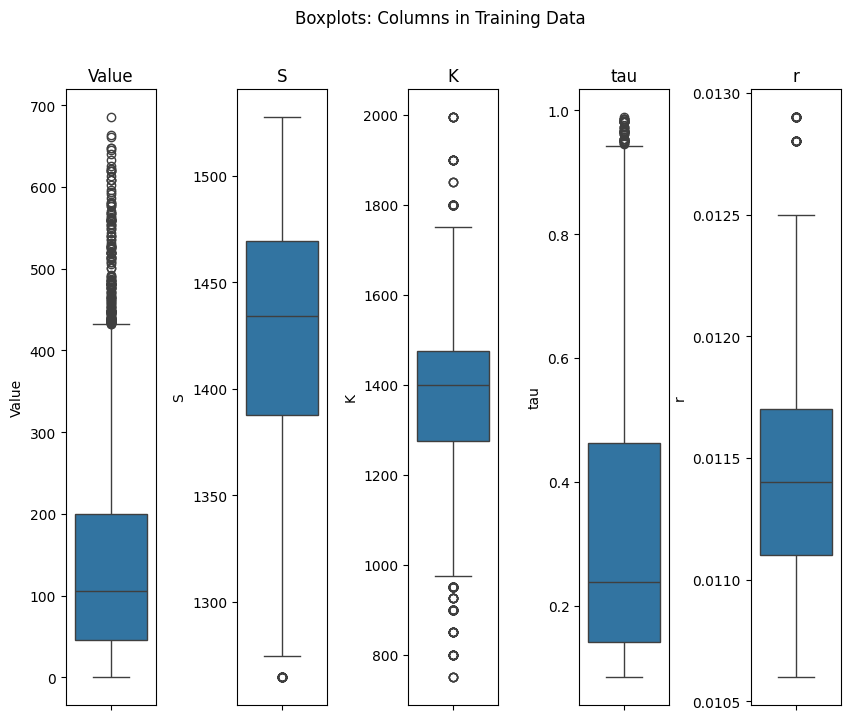

In [ ]:
# create boxplots for columns to visually examine potential outliers

fig, axes = plt.subplots(nrows=1, ncols=(len(train.columns)-1), figsize=(10,8))
plt.subplots_adjust(wspace=0.9)

for i, col in enumerate(train.columns[:-1]):
    sns.boxplot(y=col, data=train, ax=axes[i])
    axes[i].set_title(col)
plt.suptitle('Boxplots: Columns in Training Data')
plt.show()

A visual examination of the boxplots confirms that there are outliers present for each variable.

## Check: Balanced Data

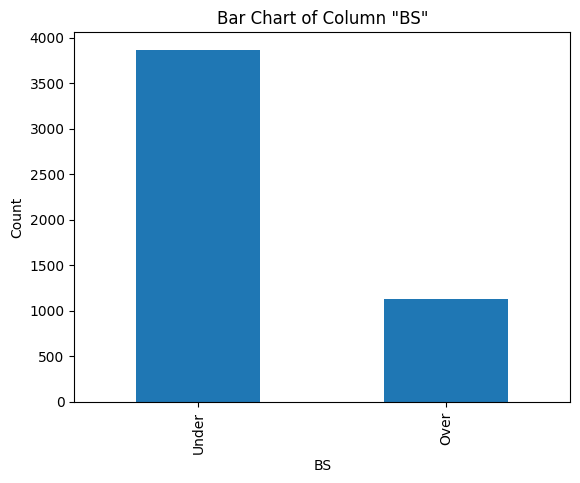

In [ ]:
# Create Bar chart of the Black Scholes column, to examine how balanced the data is

train['BS'].value_counts().plot(kind='bar')
plt.title('Bar Chart of Column "BS"')
plt.xlabel('BS')
plt.ylabel('Count')
plt.show()

We notice that the `under` classification value occurs 3x that of the `over` classification value.

As such, we propose to **use stratified k-fold cross-validation** as the technique to effectively handle this imbalanced dataset.

Stratification ensures that the proportion of the minority and majority classes is maintained in each fold, unlike regular k-fold cross-validation which can lead to folds with very few or no examples of the minority class.

## Correlation Matrix

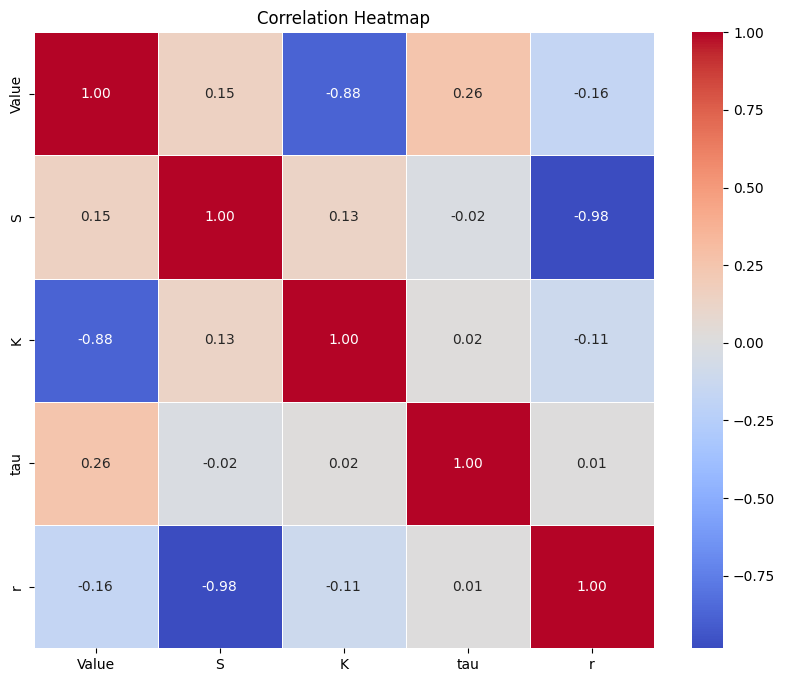

In [ ]:
corr_matrix = train.iloc[:,:5].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

Apart from two exceptions, there exists low to moderate correlation between the variables.

The relationships we must highlight include:

* **Current Option Value (`Value`) and Strike Price (`k`)**: There exists a strong negative relationship (-0.88). This association will be visually confirmed and its implication explored subsequently.
* **Current Asset Value (`S`) and Annual Risk-Free Interest Rate (`r`)**: There exists a nearly perfect negative relationship (-0.98). Intuitively, based on relative value, this makes sense. If the annual risk-free interest rate increases, stocks, as a risky asset class, become relatively less attractive. As such, we would expect their value to decrease. The inverse holds true as well.  *This is a relationship we need to monitor, to account for potential multicollinearity issues in our regression analysis.*

### Scatterplots: Predictors vs. Current Option Value (`C`)

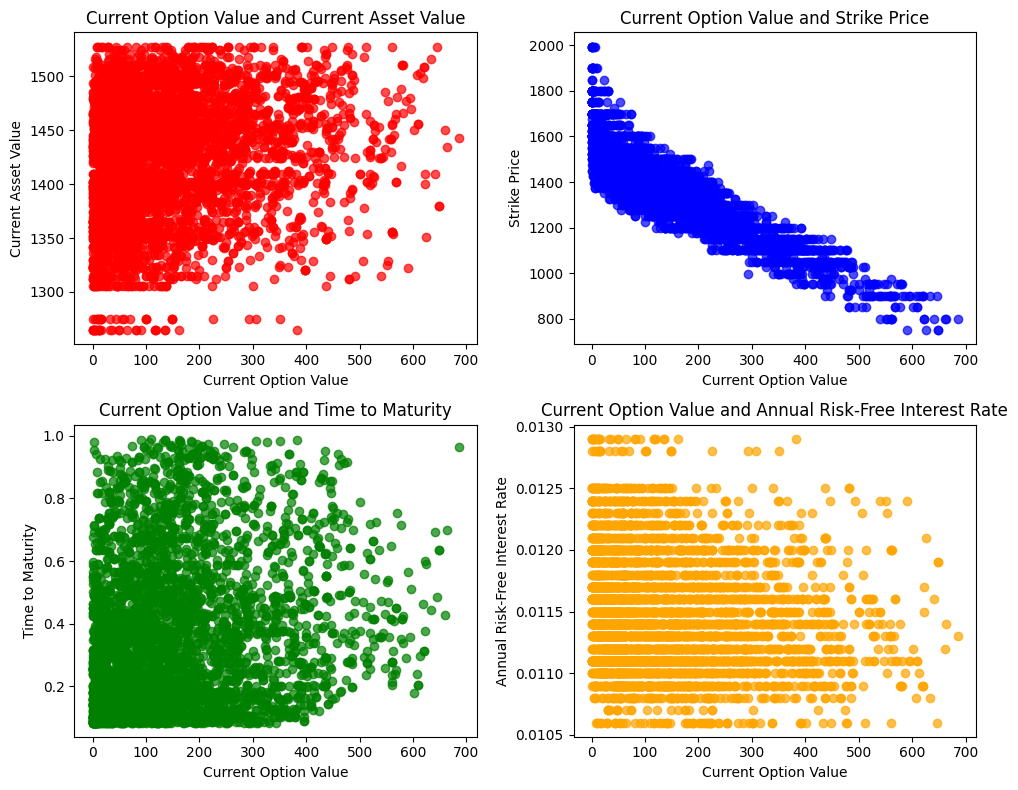

In [ ]:
# Create a 2x2 grid of scatterplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Scatterplot 1
axes[0, 0].scatter(train['Value'],train['S'], color='red', alpha=0.7)
axes[0, 0].set_title('Current Option Value and Current Asset Value')
axes[0, 0].set_xlabel('Current Option Value')
axes[0, 0].set_ylabel('Current Asset Value')

# Scatterplot 2
axes[0, 1].scatter(train['Value'],train['K'], color='blue', alpha=0.7)
axes[0, 1].set_title('Current Option Value and Strike Price')
axes[0, 1].set_xlabel('Current Option Value')
axes[0, 1].set_ylabel('Strike Price')

# Scatterplot 3
axes[1, 0].scatter(train['Value'],train['tau'], color='green', alpha=0.7)
axes[1, 0].set_title('Current Option Value and Time to Maturity')
axes[1, 0].set_xlabel('Current Option Value')
axes[1, 0].set_ylabel('Time to Maturity')

# Scatterplot 4
axes[1, 1].scatter(train['Value'],train['r'], color='orange', alpha=0.7)
axes[1, 1].set_title('Current Option Value and Annual Risk-Free Interest Rate')
axes[1, 1].set_xlabel('Current Option Value')
axes[1, 1].set_ylabel('Annual Risk-Free Interest Rate')

# Adjust layout to prevent overlapping titles
plt.tight_layout()

# Show the plot
plt.show()

These scatterplots graph our dependent variable, *Current Option Value (`C`), against each of the four predictors.

* Interestingly, there is little to no general pattern in three of the four variables (Current Asset Value, Time to Maturity, Annual Interest Rate), which visually confirms our findings of the correlation matrix.
* Supporting our prior analysis, there appears to be a strong negative relationship between the Current Option Value and the Strike Price. Intuitively, this makes sense. A lower strike price for call options increases the likelihood that such an option is "in-the-money", thereby increasing its current value.


## Consideration: Scaling

<font color="red">Is there any sort of data pre-processing we need to do? Interest rates are a percentage, therefore close to 0 - some of the price data is very high. Should we scale? </font>

## Data Preparation for Modeling

### Regression

In [ ]:
# Splitting data into X and y for training

X_train = train[['S', 'K', 'r', 'tau']]
y_train_reg = train['Value']

### Classification

In [ ]:
train['BS_Dummy'] = np.where(train['BS']=='Over',1,0)
y_train_class = train['BS_Dummy']

# Sanity Check
print(y_train_class[:6]), print(train['BS'][:6])

0    0
1    0
2    0
3    1
4    0
5    0
Name: BS_Dummy, dtype: int64
0    Under
1    Under
2    Under
3     Over
4    Under
5    Under
Name: BS, dtype: object


(None, None)

# Model Selection Procedures

We wonder whether we can nest Best Subset Selection and K-Fold Cross-Validation, or undertake Best Subset Selection first, and the conduct K-Fold Cross-Validation.

However, upon reflection, we justify our decision to not undertake Best Subset Selection by the following:

1. We only have four predictors in this scenario; and
2. Our full model performs exceptionally well using the Random Forest algorithms.

# Regression Models

## Linear Regression with 10-Fold Cross-Validation

In [ ]:
# Initialize 10-fold cross-validation with random state for reproducibility
# Shuffle to obtain representative samples

kfolds_regression = KFold(n_splits = 10, random_state = 1, shuffle = True)

### Fit the Linear Regression Model & Measure Performance

In [ ]:
linear_regression = LinearRegression()
lin_reg_cv = cross_val_score(linear_regression, X_train, y_train_reg,cv = kfolds_regression)

print("Linear Regression: \n")
print("R-Squared of the 10 Folds:",lin_reg_cv,"\n(Mean R-Squared:",np.mean(lin_reg_cv),")")

Linear Regression: 

R-Squared of the 10 Folds: [0.93455647 0.9265272  0.92840676 0.928744   0.92299048 0.93684883
 0.89697499 0.92831099 0.93380947 0.91103769] 
(Mean R-Squared: 0.9248206880985345 )


## KNN Regression Using 10-Fold Cross-Validation

In [ ]:
# Define the KNN regression model
knn_regression = KNeighborsRegressor()

# Perform 10-fold cross-validation
knn_reg_cv = cross_val_score(knn_regression, X_train, y_train_reg, cv=kfolds_regression)

# Print the results
print("KNN Regression: \n")
print("R-Squared of 10-folds:", knn_reg_cv)
print("(Mean R-Squared:", np.mean(knn_reg_cv), ")")

KNN Regression: 

R-Squared of 10-folds: [0.94925961 0.94470449 0.94146166 0.94510448 0.95120522 0.9483336
 0.9527556  0.9526477  0.95119513 0.9560414 ]
(Mean R-Squared: 0.9492708895398291 )


### Hypertuning the Number of Neighbors (Default = 5)

In [ ]:
# Define the range of k values to test
k_range = list(range(1, 31))

# Create the parameter grid
param_grid = {'n_neighbors': k_range}

# Create the KNN regression model
knn_regression = KNeighborsRegressor()

# Perform grid search with 10-fold cross-validation
grid_search = GridSearchCV(knn_regression, param_grid, cv=kfolds_regression, scoring='r2')
grid_search.fit(X_train, y_train_reg)

# Print the best hyperparameters and the corresponding mean R-squared score
print("Best Number of Neighbors:", grid_search.best_params_['n_neighbors'])
print("Mean R-squared:", grid_search.best_score_)

Best Number of Neighbors: 2
Mean R-squared: 0.9522437111742198


## Lasso Regression

### Standardization and Parameter Tuning

For Lasso and Ridge Regression, we need to (1) Standardize, and (2) Tune the `alpha` Parameter.

In [ ]:
# Standardize for Lasso and Ridge Regression

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)

In [ ]:
X_train_std

array([[-0.57424194, -1.85474684,  0.29531344, -0.86021181],
       [ 0.10002663,  0.17233687, -0.37382578,  1.52204229],
       [ 0.93237985, -0.84120499, -0.59687218,  0.50276939],
       ...,
       [-1.25047318,  0.75150364,  1.18749907,  1.49833827],
       [-1.66441948, -0.98599668,  1.63359188, -0.07797912],
       [ 0.9675296 ,  0.60671195, -0.81991859,  0.76351362]])

In [ ]:
# Assuming X_test is defined
X_test = test[['S', 'K', 'r', 'tau']]

# Transform the test data using the same scaler
X_test_std = stdsc.transform(X_test)

In [ ]:
X_test_std

array([[-0.3098159 , -0.26203822,  0.07226704, -0.87206382],
       [ 1.41537668, -1.56516346, -1.042965  , -0.0542751 ],
       [-0.30464157,  0.46192025,  0.29531344, -0.56391155],
       ...,
       [-0.53017093,  0.23025354,  0.51835985, -0.7416917 ],
       [ 0.17603573,  0.60671195, -0.15077937,  0.58573347],
       [-2.88877271, -1.56516346,  3.19491672, -0.38613139]])

### 10-Fold Cross-Validation: Find Optimal Alpha

In [ ]:
 # Create list of Alphas to Hypertune the Parameter

 alphas = 10**np.linspace(10,-2,100)*0.5

In [ ]:
lassocv = LassoCV(alphas=alphas, cv=kfolds_regression, max_iter=10000)
lassocv.fit(X_train_std, y_train_reg)
lassocv_alpha = lassocv.alpha_
print("Optimal Alpha:", lassocv_alpha)

NameError: name 'kfolds_regression' is not defined

### Fit the Lasso Model and Evaluate Performance

In [ ]:
lasso_reg = Lasso(alpha=lassocv_alpha)
lasso_reg_cv = cross_val_score(lasso_reg, X_train_std, y_train_reg, cv=kfolds_regression)

print("Lasso Regression: \n")
print("R-squared of 10-folds:", lasso_reg_cv)
print("(Mean R-squared:", np.mean(lasso_reg_cv), ")")

Lasso Regression: 

R-squared of 10-folds: [0.93455274 0.92654197 0.92840426 0.92877055 0.92299037 0.93684474
 0.89698411 0.92831098 0.93380312 0.91104528]
(Mean R-squared: 0.9248248102668727 )


## Ridge Regression

We will use the same standardized values and the alpha tuning approach employed for Lasso Regression.

### 10-Fold Cross-Validation: Find Optimal Alpha

In [ ]:
# Finding the optimal Alpha

ridgecv_alpha_model = RidgeCV(alphas=alphas, scoring='r2', cv=kfolds_regression)
ridgecv_alpha_model.fit(X_train_std, y_train_reg)
ridgecv_alpha = ridgecv_alpha_model.alpha_
print(ridgecv_alpha)

3.0679536367065814


### Fit the Ridge Model and Evaluate Performance

In [ ]:
ridge_reg = Ridge(alpha=ridgecv_alpha)
ridge_reg_cv = cross_val_score(ridge_reg, X_train_std, y_train_reg,cv = kfolds_regression)

print("Ridge Regression: \n")
print("R Squared of 10-folds:",ridge_reg_cv)
print("(Mean R-squared:",np.mean(ridge_reg_cv),")")

Ridge Regression: 

R Squared of 10-folds: [0.93451669 0.92655347 0.92839061 0.92878602 0.92298969 0.93680927
 0.89706672 0.92828628 0.933771   0.9110509 ]
(Mean R-squared: 0.9248220674543666 )


## Decision Tree Regression

In [ ]:
decisiontree_regression = DecisionTreeRegressor(random_state=42)
dt_reg_cv = cross_val_score(decisiontree_regression, X_train, y_train_reg,cv = kfolds_regression)

print("Decision Tree Regression: \n")
print("R-Squared of 10-folds:",dt_reg_cv)
print("(Mean R-Squared:",np.mean(dt_reg_cv),")")

Decision Tree Regression: 

R-Squared of 10-folds: [0.99365316 0.99225234 0.99322849 0.99269744 0.99355157 0.99338723
 0.99368055 0.99466547 0.99361759 0.99340008]
(Mean R-Squared: 0.9934133917143726 )


In [ ]:
# Fit the Decision Tree Regressor on the training data
decisiontree_regression.fit(X_train, y_train_reg)

# Make predictions on the test set
predictions_dt = decisiontree_regression.predict(X_test)

In [ ]:
predictions_dt[:20]

array([117.375, 437.375,  35.   , 183.75 , 214.5  , 271.125,  47.5  ,
       245.   , 288.5  ,  86.5  ,  63.   , 124.375,   9.25 ,  81.5  ,
       200.875,  24.   ,  32.5  ,  46.25 ,  23.125,  71.25 ])

In [ ]:
# Define the parameter grid
param_grid = {
    'max_depth': [2, 5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['friedman_mse', 'squared_error', 'absolute_error']
}

In [ ]:
# Create the Decision Tree Regressor
decisiontree_regression = DecisionTreeRegressor(random_state=42)

# Perform grid search with 10-fold cross-validation
grid_search = GridSearchCV(decisiontree_regression, param_grid, cv=kfolds_regression, scoring='r2')
grid_search.fit(X_train, y_train_reg)

# Print the best hyperparameters and the corresponding mean R-squared score
print("Best Hyperparameters:", grid_search.best_params_)
print("Mean R-squared:", grid_search.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/di

Best Hyperparameters: {'criterion': 'friedman_mse', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2}
Mean R-squared: 0.9934172921826997


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


Our output is as follows, upon hypertuning:

* Best Hyperparameters: `{'criterion': 'friedman_mse', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2}`

* Mean R-squared: 0.9934172921826997

## Random Forest Regression

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [ ]:
# Create the Random Forest Regressor
randomforest_regression = RandomForestRegressor(random_state=42)

# Perform grid search with 10-fold cross-validation
rf_grid_search = GridSearchCV(randomforest_regression, param_grid, cv=kfolds_regression, scoring='r2')
rf_grid_search.fit(X_train, y_train_reg)

# Print the best hyperparameters and the corresponding mean R-squared score
print("Best Hyperparameters:", rf_grid_search.best_params_)
print("Mean R-squared:", rf_grid_search.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

Best Hyperparameters: {'max_depth': None, 'max_features': 'auto', 'n_estimators': 300}
Mean R-squared: 0.9968477581297763


Our output is as follows, upon hypertuning:

* Best Hyperparameters: `{'max_depth': None, 'max_features': 'auto', 'n_estimators': 300}`
* Mean R-squared: 0.9968477581297763

In [ ]:
rf1 = RandomForestRegressor(random_state=42, max_depth = None, max_features = 1.0, n_estimators = 300)

In [ ]:
rf1.fit(X_train, y_train_reg)

RandomForestRegressor(n_estimators=300, random_state=42)

In [ ]:
y_reg_pred_rf = rf1.predict(X_test)

In [ ]:
y_reg_pred_rf[:20]

array([112.05458333, 427.76083333,  43.08208333, 180.30458333,
       220.8875    , 267.58291667,  42.06375   , 255.54125   ,
       286.08708333,  98.61708333,  76.6725    , 132.41875   ,
        10.96791667,  89.57375   , 185.15458333,  23.37125   ,
        32.00208333,  45.95416667,  31.22791667,  70.28708333])

In [ ]:
y_reg_pred_rf.mean(), y_reg_pred_rf.max(), y_reg_pred_rf.min()

(142.25697145833334, 622.4841666666666, 0.478125)

In [ ]:
# Make predictions on the standardized test set
predictions_rf = rf_grid_search.best_estimator_.predict(X_test)

In [ ]:
predictions_rf[:20]

array([112.05458333, 427.76083333,  43.08208333, 180.30458333,
       220.8875    , 267.58291667,  42.06375   , 255.54125   ,
       286.08708333,  98.61708333,  76.6725    , 132.41875   ,
        10.96791667,  89.57375   , 185.15458333,  23.37125   ,
        32.00208333,  45.95416667,  31.22791667,  70.28708333])

## Support Vector Machine Regression

In [ ]:
# Define the parameter grid
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.1, 0.5, 1, 2],
    'gamma': ['scale', 'auto']
}

# Create the SVR model
svm_regression = SVR()

# Perform grid search with 10-fold cross-validation
sv_grid_search = GridSearchCV(svm_regression, param_grid, cv=kfolds_regression, scoring='r2')
sv_grid_search.fit(X_train_std, y_train_reg)

# Print the best hyperparameters and the corresponding mean R-squared score
print("Best Hyperparameters:", sv_grid_search.best_params_)
print("Mean R-squared:", sv_grid_search.best_score_)

Best Hyperparameters: {'C': 100, 'epsilon': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Mean R-squared: 0.9973791440237616


## Final Regression Model and Prediction

The final model selected is **Support Vector Machine Regression**, which during our training, gave us the best Mean R-Squared: 0.9973791440237616.

In [ ]:
svm1 = SVR(C = 100, epsilon = 2, gamma = 'scale', kernel = 'rbf')

In [ ]:
svm1.fit(X_train_std, y_train_reg)

SVR(C=100, epsilon=2)

In [ ]:
y_reg_pred_svm = svm1.predict(X_test_std)

In [ ]:
y_reg_pred_svm[:20]

array([106.83074012, 423.6063136 ,  40.32829585, 169.93643464,
       215.97439797, 279.39681875,  40.25578216, 250.1699445 ,
       290.949094  , 106.83920755,  73.56247932, 133.15865164,
         8.49290734,  84.40758862, 193.21580012,  20.00104433,
        36.4766837 ,  47.62133005,  28.09195988,  69.75203031])

In [ ]:
y_reg_pred_svm.mean(), y_reg_pred_svm.max(), y_reg_pred_svm.min()

(142.7006970467568, 613.992336804301, -2.6043975315260184)

In [ ]:
# Imputing negative values to 0

y_reg_pred_svm1 = np.maximum(y_reg_pred_svm, 0)

In [ ]:
y_reg_pred_svm1.mean(), y_reg_pred_svm1.max(), y_reg_pred_svm1.min()

(142.7066461207974, 613.992336804301, 0.0)

# Classification Models

## Using Stratified K-Folds for Cross-Validation

In [ ]:
kfolds_class = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

## Preparing our Data for Classification

In [ ]:
df = pd.DataFrame(X_train)
df['y'] = y_train_class
df = df.reset_index(drop=True)

X_train = df.drop('y', axis=1)
y_train_class = df['y']

## Logistic Regression

In [ ]:
logistic_regression = LogisticRegression()
log_reg_cv = cross_val_score(logistic_regression, X_train, y_train_class,cv = kfolds_class)

print("Logistic Regression: \n")
print("Accuracies of 10-folds:",log_reg_cv)
print("Mean Classification Error:",1-np.mean(log_reg_cv))

Logistic Regression: 

Accuracies of 10-folds: [0.902 0.874 0.89  0.896 0.866 0.866 0.856 0.88  0.844 0.85 ]
Mean Classification Error: 0.12759999999999994


## KNN Classification

In [ ]:
# Define the range of k values to test
k_range = list(range(1, 31))

# Create the parameter grid
param_grid = {'n_neighbors': k_range}

# Create the KNN classification model
knn_classifier = KNeighborsClassifier()

# Perform grid search with 10-fold cross-validation
grid_search = GridSearchCV(knn_classifier, param_grid, cv=kfolds_class, scoring='accuracy')
grid_search.fit(X_train, y_train_class)

# Print the best hyperparameters and the corresponding mean accuracy score
print("Best Number of Neighbors:", grid_search.best_params_['n_neighbors'])
print("Mean Accuracy:", grid_search.best_score_)

# Calculate the mean classification error
mean_classification_error = 1 - grid_search.best_score_

print("Mean Classification Error:", mean_classification_error)

Best Number of Neighbors: 1
Mean Accuracy: 0.8874000000000001
Mean Classification Error: 0.11259999999999992


## Linear Discriminant Analysis

In [ ]:
lda = LinearDiscriminantAnalysis()
lda_cv = cross_val_score(lda, X_train, y_train_class,cv = kfolds_class)

print("Linear Discriminant Analysis: \n")
print("Accuracies of 10-folds:",lda_cv)
print("Mean Classification Error:", 1-np.mean(lda_cv))

Linear Discriminant Analysis: 

Accuracies of 10-folds: [0.876 0.866 0.878 0.872 0.846 0.87  0.874 0.872 0.866 0.872]
Mean Classification Error: 0.13080000000000003


## Decision Tree Classification

### Determining the Optimal Alpha

In [ ]:
# Assuming you have X_train and y_train_class
clf_tree = DecisionTreeClassifier(random_state=0)

# Get the cost-complexity pruning path
path = clf_tree.cost_complexity_pruning_path(X_train, y_train_class)
ccp_alphas = path.ccp_alphas

# Evaluate the model for each alpha value
accuracies = []
for ccp_alpha in ccp_alphas:
    scores = []
    for train_index, test_index in kfolds_class.split(X_train, y_train_class):
        clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
        clf.fit(X_train.iloc[train_index], y_train_class.iloc[train_index])
        y_pred = clf.predict(X_train.iloc[test_index])
        score = accuracy_score(y_train_class.iloc[test_index], y_pred)
        scores.append(score)
    accuracies.append(np.mean(scores))

# Find the index of the maximum accuracy
best_alpha_idx = np.argmax(accuracies)
best_alpha = ccp_alphas[best_alpha_idx]

print("The accuracies:", accuracies)
print("\nThe best alpha value:", best_alpha)

The accuracies: [0.9178000000000001, 0.9178000000000001, 0.9178000000000001, 0.9182, 0.9178000000000001, 0.9178000000000001, 0.9178000000000001, 0.9178000000000001, 0.9178000000000001, 0.9178000000000001, 0.9179999999999999, 0.9179999999999999, 0.9179999999999999, 0.9179999999999999, 0.9179999999999999, 0.9179999999999999, 0.9179999999999999, 0.9186000000000002, 0.9190000000000002, 0.9188000000000001, 0.9188000000000001, 0.9188000000000001, 0.9188000000000001, 0.9188000000000001, 0.9186, 0.9184000000000001, 0.9186, 0.9186, 0.9186, 0.9186, 0.9186, 0.9183999999999999, 0.9183999999999999, 0.9183999999999999, 0.9183999999999999, 0.9183999999999999, 0.9183999999999999, 0.9183999999999999, 0.9186, 0.9186, 0.9183999999999999, 0.9183999999999999, 0.9183999999999999, 0.9183999999999999, 0.9183999999999999, 0.9182, 0.9182, 0.9182, 0.9182, 0.9182, 0.9176, 0.917, 0.9168000000000001, 0.9168000000000001, 0.9166000000000002, 0.9166000000000002, 0.9166000000000002, 0.9166000000000002, 0.91660000000000

In [ ]:
dt_class = DecisionTreeClassifier(random_state=0, ccp_alpha=best_alpha)
dt_class_cv = cross_val_score(dt_class, X_train, y_train_class,cv = kfolds_class)

print("Decision Tree Classification: \n")
print("Accuracies of 10-folds:",dt_class_cv)
print("Mean classification error:",1-np.mean(dt_class_cv))

Decision Tree Classification: 

Accuracies of 10-folds: [0.926 0.918 0.902 0.934 0.916 0.934 0.918 0.92  0.91  0.912]
Mean classification error: 0.08099999999999985


## Random Forest Classification

In [ ]:
# Create the base model
rf_class = RandomForestClassifier(random_state=0)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_class,
                           param_grid=param_grid,
                           cv=5,  # Number of folds for cross-validation
                           scoring='accuracy',
                           n_jobs=-1)  # Use all available CPU cores

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train_class)

# Get the best estimator and its parameters
best_rf_class = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate the best model
best_rf_class_cv = cross_val_score(best_rf_class, X_train, y_train_class, cv= kfolds_class)

print("Best Parameters:", best_params)
print("Best Random Forest Classification:")
print("Accuracies of 10-folds:", best_rf_class_cv)
print("Mean Classification Error:", 1 - best_rf_class_cv.mean())

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Random Forest Classification:
Accuracies of 10-folds: [0.936 0.938 0.926 0.948 0.934 0.946 0.926 0.948 0.942 0.932]
Mean Classification Error: 0.0623999999999999


## Gradient Boosting Classification

In [ ]:
# Create the base model
gb_classifier = GradientBoostingClassifier(random_state=0)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=gb_classifier,
                           param_grid=param_grid,
                           cv=5,  # Number of folds for cross-validation
                           scoring='accuracy',
                           n_jobs=-1)  # Use all available CPU cores

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train_class)

# Get the best estimator and its parameters
best_gb_classifier = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate the best model
best_gb_class_cv = cross_val_score(best_gb_classifier, X_train, y_train_class, cv=kfolds_class)

print("Best Parameters:", best_params)
print("Best Gradient Boosting Classification:")
print("Accuracies of 10-folds:", best_gb_class_cv)
print("Mean Accuracy:", best_gb_class_cv.mean())
print("Mean Classification Error:", 1 - best_gb_class_cv.mean())

Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best Gradient Boosting Classification:
Accuracies of 10-folds: [0.936 0.948 0.932 0.954 0.924 0.958 0.936 0.946 0.942 0.936]
Mean Accuracy: 0.9412
Mean Classification Error: 0.05879999999999996


In [ ]:
# Extra stuff
# Test
y_pred_gb = best_gb_classifier.predict(X_test)

In [ ]:
y_pred_gb[:20]

# Seems to be giving the same output as in XGBoost

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0])

## XGBoost Classification

In [ ]:
# Create the base model
xgb_classifier = XGBClassifier(random_state=0)

# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_classifier,
                           param_grid=param_grid,
                           cv=5,  # Number of folds for cross-validation
                           scoring='accuracy',
                           n_jobs=-1)  # Use all available CPU cores

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train_class)

# Get the best estimator and its parameters
best_xgb_classifier = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate the best model
best_xgb_class_cv = cross_val_score(best_xgb_classifier, X_train, y_train_class, cv = kfolds_class)

print("Best Parameters:", best_params)
print("Best XGBoost Classification:")
print("Accuracies of 10-folds:", best_xgb_class_cv)
print("Mean Accuracy:", best_xgb_class_cv.mean())
print("Mean Classification Error:", 1 - best_xgb_class_cv.mean())

Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}
Best XGBoost Classification:
Accuracies of 10-folds: [0.946 0.954 0.932 0.94  0.93  0.95  0.938 0.944 0.938 0.944]
Mean Accuracy: 0.9416
Mean Classification Error: 0.05840000000000001


## Final Classification Model and Prediction

The final model selected is **XGBoost Classification**, which during our training, gave us the best Mean Classification Error: 0.05840000000000001.

In [ ]:
xgb = XGBClassifier(random_state=0, colsample_bytree = 0.8, gamma = 0, learning_rate = 0.1, max_depth = 7, min_child_weight = 1, n_estimators = 300, subsample = 1.0)

In [ ]:
xgb.fit(X_train, y_train_class)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [ ]:
y_pred_class_xgb = xgb.predict(X_test)

In [ ]:
y_pred_class_xgb[:20]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0])

In [ ]:
# Extra trial
# Need to get predictions for the test data

# Make predictions on the test set
y_pred = best_xgb_classifier.predict(X_test)

In [ ]:
# Sanity check

y_pred[:20]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0])

# Exporting Predictions to `csv`

In [ ]:
predictions = pd.DataFrame({'Value': y_reg_pred_svm1, 'BS': y_pred_class_xgb})

In [ ]:
predictions.head(5)

,Value,BS
0,106.830740,0
1,423.606314,0
2,40.328296,0
3,169.936435,0
4,215.974398,0


In [ ]:
predictions.to_csv('group_13_predictions.csv', index=False)